In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController, ControlNoiseInit
from utils import transform_angle_error, transform_02pi_to_negpospi, Simulator, ParametricPath, Trajectory

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint

plt.style.use(["science", "grid", "vibrant"])
ls = {"loose dash": (0, (5, 10)), "dash": (0, (5, 5))}

# Pendulum
Try MPPI controller with a pendulum:
![alternatvie text](http://underactuated.mit.edu/figures/simple_pend.svg)

The state-space representation of the system is $x = (\theta, \dot{\theta})$, $u = \tau$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{\tau - mgl\sin(\theta) - b\dot{\theta}}{ml^2}
\end{align*}
$$

### Controller Definition

In [19]:
from systems.dynamical_systems import Pendulum

pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

def terminal_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([1000, 1])

    return error.T @ Q @ error


def state_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1

    error = np.array([theta_error])
    Q = np.diag([1000])

    return error.T @ Q @ error

pend_controller = SystemController(
    ds=pend,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([2.0 ** 2]),
    exploration_lambda=2e1,
    alpha_mu=0.5,
    alpha_sigma=0.95,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": pend.u_lo, "max": pend.u_hi},
    control_noise_initialization=ControlNoiseInit.ZERO
)

### Simulation Definition

In [20]:
INITIAL_STATE = np.array([np.radians(0), 0])

pend_env = Simulator(pend, controller=pend_controller)
states, controls, time = pend_env.run(simulation_length=16, initial_state=INITIAL_STATE, controlled=True)

scores mean: 0.010000000000000004, var: 0.009898567600156864, min: 1.5136766976755553e-15, max: 0.999928376413862
scores mean: 0.009999999999999997, var: 0.009451959820085553, min: 2.7789169029572973e-24, max: 0.9771889047765888
scores mean: 0.01, var: 0.009760010644305702, min: 8.066577997161662e-32, max: 0.9929536570023788
scores mean: 0.009999999999999998, var: 0.005202026641956381, min: 3.785072841606863e-33, max: 0.6238312249662687
scores mean: 0.009999999999999998, var: 0.009879670036996812, min: 1.557727640933395e-36, max: 0.9989826987246055
scores mean: 0.010000000000000002, var: 0.009897677803588557, min: 1.5480295128128363e-30, max: 0.9998838789513758
scores mean: 0.009999999999999997, var: 0.0023981391234325455, min: 7.755298757089423e-29, max: 0.3525522996629505
scores mean: 0.009999999999999998, var: 0.002932809269322644, min: 2.984064224644004e-23, max: 0.43066476116372393
scores mean: 0.010000000000000004, var: 0.00805676552596697, min: 1.8686516104519277e-14, max: 0.902

### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_22391/793666409.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


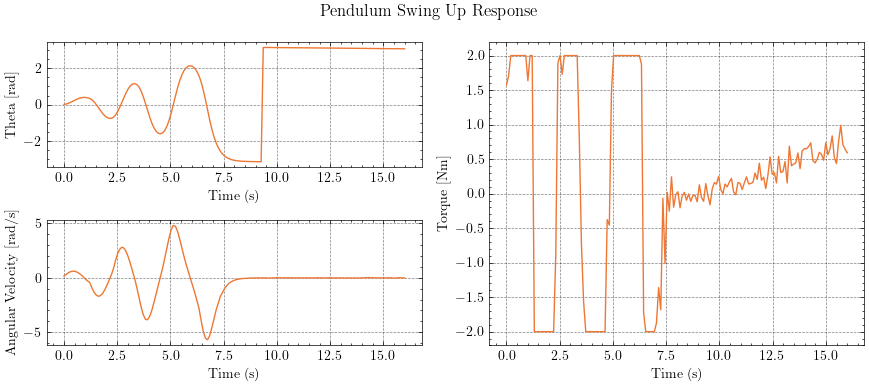

In [21]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'r'], ['ll', 'r']], figsize=(9, 4), layout="constrained")

fig.suptitle("Pendulum Swing Up Response")

axd["ul"].plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Theta")
axd["ul"].set(xlabel="Time (s)", ylabel="Theta [rad]")

axd["ll"].plot(time, states[:, 1], label="Angular Velocity")
axd["ll"].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")

axd["r"].plot(time, controls[:, 0])
axd["r"].set(xlabel="Time (s)", ylabel="Torque [Nm]")

plt.tight_layout()
fig.savefig("figs/gt_pendulum_swingup.png")

## Pendulum Control with Inverse Dynamics
Use a linearization technique to have the MPC controller use inputs $u = \ddot{\theta}$, where MPC returns a desired acceleration, $\ddot{\theta}_d$, to be conerted into system input torque $\tau$ as $\tau = f(\ddot{\theta}_d)$, where the function $f$ for a pendulum is defined as its inverse dynamics:
$$
f(\ddot{\theta}_d) = \tau_d = \ddot{\theta}_d m l^2 + b\dot{\theta} + mgl\sin(\theta)
$$

In [4]:
alpha_mag = np.array([2])

pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 20)
pend_controller = SystemController(
    ds=pend,
    n_rollouts=150,
    horizon_length=12,
    exploration_cov=np.diag([1 ** 2]),
    exploration_lambda=1e-6,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": -alpha_mag, "max": alpha_mag},
    include_null_controls=True,
    inverse_dyn_control=True
)

NameError: name 'Pendulum' is not defined

In [6]:
INITIAL_STATE = np.array([np.radians(0), 0])

pend_env = Simulator(pend, controller=pend_controller)
states, controls, time = pend_env.run(simulation_length=5, initial_state=INITIAL_STATE, controlled=True)

NameError: name 'pend' is not defined

NameError: name 'states' is not defined

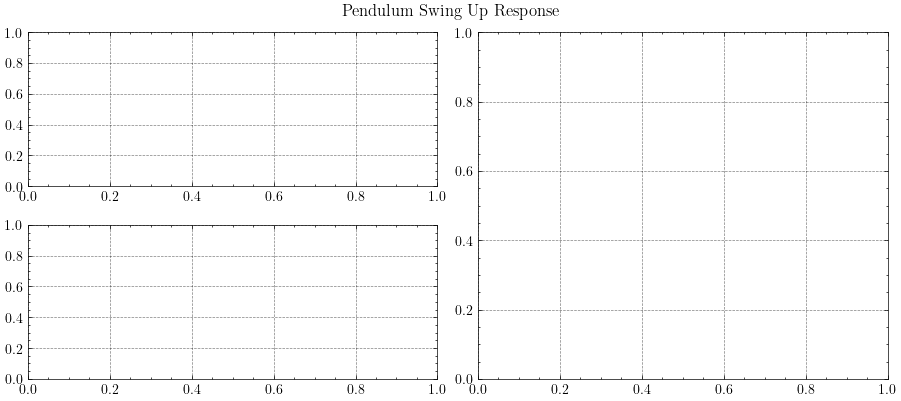

In [7]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'r'], ['ll', 'r']], figsize=(9, 4), layout="constrained")

fig.suptitle("Pendulum Swing Up Response")

axd["ul"].plot(time, states[:, 0], label="Theta")
axd["ul"].set(xlabel="Time (s)", ylabel="Theta [rad]")

axd["ll"].plot(time, states[:, 1], label="Angular Velocity")
axd["ll"].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")

axd["r"].plot(time, controls[:, 0])
axd["r"].set(xlabel="Time (s)", ylabel="Torque [Nm]")

plt.tight_layout()
fig.savefig("figs/pendulum_swingup_invd.png")

# Cart-Pole
Try MPPI controller with a cart-pole system:

![alternatvie text](http://underactuated.mit.edu/figures/cartpole.svg)

The state-space representation of the system is $x = (x, \dot{x}, \theta, \dot{\theta})$, $u = f_x$, and the dynamics of the inverted pendulum are given by:
$$
\begin{align*}
    \dot{x} &= \dot{x} \\
    \ddot{x} &= \frac{1}{m_c+m_p\sin^2(\theta)} \left( f_x + m_p\sin(\theta) (l\dot{\theta}^2 + g\cos(\theta)) \right) \\
    \dot{\theta} &= \dot{\theta} \\
    \ddot{\theta} &= \frac{1}{l(m_c+m_p\sin^2(\theta))} \left( -f_x\cos(\theta) - m_p l \dot{\theta}^2 \cos(\theta)\sin(\theta) - (m_c + m_p)g\sin(\theta) \right)
\end{align*}
$$

### Controller Definition

In [10]:
from systems.dynamical_systems import CartPole

cartpole = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 0.0

# Define the controller cost functions

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([5e4, 1e2, 5e4])

    return error.T @ Q @ error

def state_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1

    error = np.array([theta_error])
    Q = np.diag([6e4])

    return error.T @ Q @ error

cartpole_controller = SystemController(
    ds=cartpole,
    n_rollouts=200,
    horizon_length=10,
    exploration_cov=np.diag([10.0 ** 2]),
    exploration_lambda=1e-2,
    alpha_mu=0.5,
    alpha_sigma=0.985,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": cartpole.u_lo, "max": cartpole.u_hi},
    control_noise_initialization=ControlNoiseInit.ZERO
)

### Simulation Definition

In [13]:
INITIAL_STATE = np.array([0.0, 0.0, np.radians(0.0), 0.0])

cartpole_env = Simulator(cartpole, controller=cartpole_controller)
states, controls, time = cartpole_env.run(simulation_length=8, initial_state=INITIAL_STATE, controlled=True)

[Simulator] [Info] cart_pole simulation elapsed time: 7.13941 s


### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_19229/2847489924.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


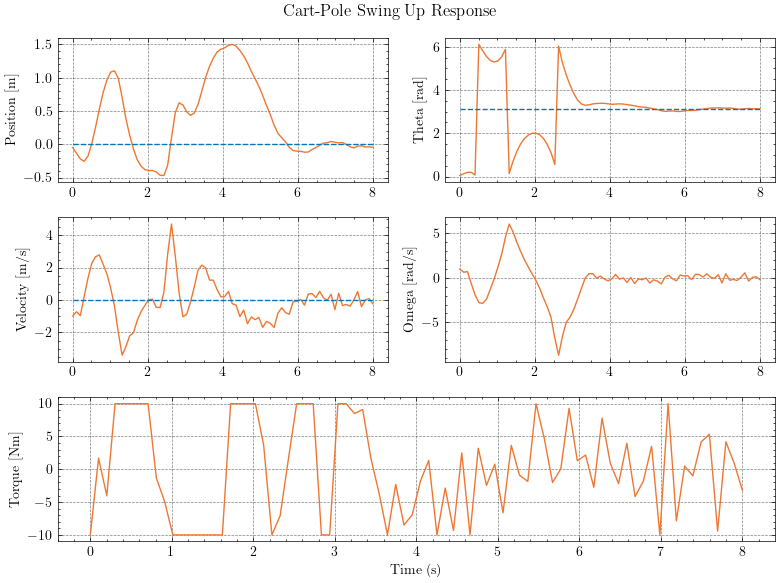

In [15]:
# Plot the results
fig, axd = plt.subplot_mosaic([['pos', 'theta'],
                               ['vel', 'omega'],
                               ['tau', 'tau']], figsize=(8, 6), layout="constrained")

fig.suptitle("Cart-Pole Swing Up Response")

axd['pos'].plot(time, states[:, 0])
axd['pos'].plot(time, [DESIRED_CARTPOS]*len(time), "--")
axd['pos'].set(ylabel="Position [m]")

axd['vel'].plot(time, states[:, 1])
axd['vel'].plot(time, [DESIRED_CARTVEL]*len(time), "--")
axd['vel'].set(ylabel="Velocity [m/s]")

axd['theta'].plot(time, states[:, 2])
axd['theta'].plot(time, [DESIRED_THETA]*len(time), "--")
axd['theta'].set(ylabel="Theta [rad]")

axd['omega'].plot(time, states[:, 3])
axd['omega'].set(ylabel="Omega [rad/s]")

axd['tau'].plot(time, controls[:, 0])
axd['tau'].set(ylabel="Torque [Nm]")

plt.xlabel("Time (s)")
plt.tight_layout()

fig.savefig("figs/cartpole_swingup.png")

# Planar 2R Dynamic Arm
Try MPPI controller with a planar two-link robot arm modeled with its EOMs. The MPPI controller acts on a purely kinematic model of the arm, but the simulation uses the modeled arm EOMs. To translate between desired joint accelerations and torques, the arm's inverse dynamics are used:

$$
\tau_d = M(\theta)\ddot{\theta_d} + C(\theta, \dot{\theta})\dot(\theta) - \tau_g
$$

### Controller Definition

In [2]:
from systems.dynamical_systems import Planar2RArm, FK2R, IK2R

M1 = M2 = 1
L1 = L2 = 1
R1 = R2 = L1 / 2
I1 = I2 = 1/3 * M1 * L1**2

arm = Planar2RArm(
    m1=M1, m2=M2, l1=L1, l2=L2, r1=R1, r2=R2, I1=I1, I2=I2, dt=1/20
)

ik = IK2R(arm)

DESIRED_POSITION = np.array([1, 1])
ACCEL_STDDEV = 3.0

# Define the controller cost functions
def terminal_cost(x):
    t1, dot_t1, t2, dot_t2, _, _ = x
    
    pose = arm.fk(t1, t2)
    pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])
    
    error = np.array([pos_error, dot_t1, dot_t2])
    Q = np.diag([5e2, 5e2, 5e2])
    
    return np.dot(error, np.dot(Q, error))

def state_cost(x):
    t1, dot_t1, t2, dot_t2, _, _ = x
    
    pose = arm.fk(t1, t2)
    pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])
    
    error = np.array([pos_error])
    Q = np.diag([5e2])
    
    return np.dot(error, np.dot(Q, error))

arm.u_lo = np.array([-4.0, -4.0])
arm.u_hi = -arm.u_lo

arm_controller = SystemController(
    ds=arm,
    inverse_dyn_control=True,
    n_rollouts=200,
    horizon_length=25,
    exploration_cov=np.diag([ACCEL_STDDEV ** 2, ACCEL_STDDEV ** 2]),
    exploration_lambda=2e1,
    alpha_mu=0.1,
    alpha_sigma=0.95,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": arm.u_lo, "max": arm.u_hi},
    include_null_controls=False,
)

### Simulation Definition

In [3]:
INITIAL_STATE = np.array([np.pi/2, 0, 0, 0, 0, 1])

arm_env = Simulator(arm, controller=arm_controller)
states, controls, time = arm_env.run(simulation_length=5, initial_state=INITIAL_STATE, controlled=True,
                                     debug=False)
# print(controls)

[Simulator] [Info] planar_2r_arm simulation elapsed time: 6.99928 s


/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_30829/302287314.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


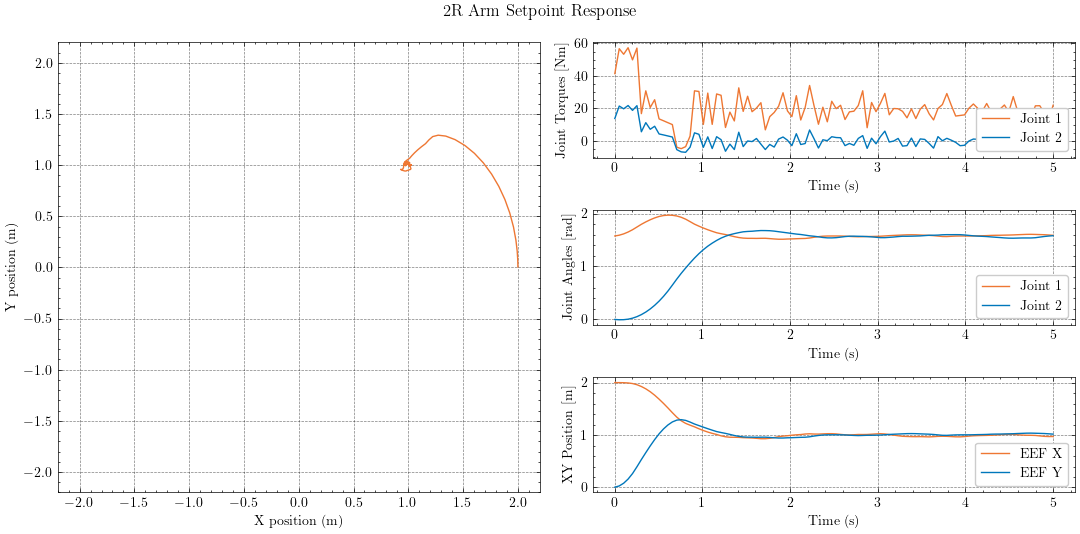

In [4]:
# Plot the results
fig, axd = plt.subplot_mosaic([['p', 't'], ['p', 'ja'], ['p', 'xy']], figsize=(11, 5.5), layout="constrained")
fig.suptitle("2R Arm Setpoint Response")

fk_v = np.vectorize(arm.fk, signature="(),()->(3)")

eef_positions = fk_v(states[:, 0], states[:, 2])

axd['p'].plot(eef_positions[:, 0], eef_positions[:, 1])
axd['p'].set(ylabel="Y position (m)", xlabel="X position (m)", ylim=(-2.2, 2.2), xlim=(-2.2, 2.2))

axd['t'].plot(time, controls[:, 0], label="Joint 1")
axd['t'].plot(time, controls[:, 1], label="Joint 2")

axd['t'].set(xlabel="Time (s)", ylabel="Joint Torques [Nm]")
axd['t'].legend(loc="lower right")

axd['ja'].plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Joint 1")
axd['ja'].plot(time, transform_02pi_to_negpospi(states[:, 2]), label="Joint 2")

axd['ja'].set(xlabel="Time (s)", ylabel="Joint Angles [rad]")
axd['ja'].legend(loc="lower right")

axd['xy'].plot(time, eef_positions[:, 0], label="EEF X")
axd['xy'].plot(time, eef_positions[:, 1], label="EEF Y")
axd['xy'].set(xlabel="Time (s)", ylabel="XY Position [m]")
axd['xy'].legend(loc="lower right")

plt.tight_layout()
fig.savefig("figs/arm_upright.png")

## Planar 2R Dynamic Arm with Path Following
Follow a parametric path using MPPI for the dynamic 2R planar arm.

In [23]:
def line(t):
    L=1.5
    return np.array([L*(1-t) + 2 - L, 0.0])

def semicircle(t):
    R = 2
    return np.array([R*np.cos(np.pi*t)+(2-R), R*np.sin(np.pi*t)])

def circle(t):
    R, tau = 0.8, 2*np.pi
    return np.array([R*np.cos(tau*t)+(2-R), R*np.sin(tau*t)])

def infty(t):
    R, tau = 2, 2*np.pi
    return np.array([R*np.cos(tau*t), R*np.sin(tau*t)*np.cos(tau*t)])

path = ParametricPath(parametric_eqn=infty, time_length=8)

def joint_semicircle(t):
    return np.array([np.pi*t + np.pi/2, 0])

def joint_rangle(t):
    return np.array([np.pi/2 * t + np.pi/2, np.pi/2 * t])

joint_path = ParametricPath(parametric_eqn=joint_semicircle, time_length=4)

In [31]:
ACCEL_STDDEV = 3.0

# Define the controller cost functions
def terminal_cost(path):
    def tc(x):
        t1, dot_t1, t2, dot_t2, param, _ = x
        DESIRED_POSITION = path(param)
    
        pose = arm.fk(t1, t2)
        pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

        error = np.array([pos_error, dot_t1, dot_t2])
        Q = np.diag([5e2, 5e2, 5e1])

        # DESIRED_T1, DESIRED_T2 = joint_path(param)
        # t1_error = np.cos(t1 - DESIRED_T1 + np.pi) + 1
        # t2_error = np.cos(t2 - DESIRED_T2 + np.pi) + 1
        
        # error = np.array([t1_error, t2_error])
        # Q = np.diag([2e4, 2e4])

        return np.dot(error, np.dot(Q, error))
    return tc

def state_cost(path):
    def sc(x):
        t1, dot_t1, t2, dot_t2, param, _ = x
        DESIRED_POSITION = path(param)

        pose = arm.fk(t1, t2)
        pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

        error = np.array([pos_error])
        Q = np.diag([5e3])

        # DESIRED_T1, DESIRED_T2 = joint_path(param)
        # t1_error = np.cos(t1 - DESIRED_T1 + np.pi) + 1
        # t2_error = np.cos(t2 - DESIRED_T2 + np.pi) + 1
        
        # error = np.array([t1_error, t2_error])
        # Q = np.diag([2e4, 2e4])

        return np.dot(error, np.dot(Q, error))
    return sc

arm.u_lo = np.array([-8.0, -8.0])
arm.u_hi = -arm.u_lo

arm_controller = SystemController(
    ds=arm,
    inverse_dyn_control=True,
    n_rollouts=150,
    horizon_length=30,
    exploration_cov=np.diag([ACCEL_STDDEV ** 2, ACCEL_STDDEV ** 2]),
    exploration_lambda=1e2,
    alpha_mu=0.1,
    alpha_sigma=0.98,
    terminal_cost=terminal_cost(path),
    state_cost=state_cost(path),
    control_range={"min": arm.u_lo, "max": arm.u_hi},
    include_null_controls=False,
    control_noise_initialization=ControlNoiseInit.ZERO
)

In [32]:
T1_0, T2_0 = ik.solve(np.array([2, 0, 0])) + np.array([np.pi/2, 0])
INITIAL_STATE = np.array([T1_0, 0, T2_0, 0, 0, 1])

arm_env = Simulator(arm, controller=arm_controller)
states, controls, times = arm_env.run(simulation_length=9, initial_state=INITIAL_STATE, controlled=True,
                                      debug=False)

[Simulator] [Info] planar_2r_arm simulation elapsed time: 18.80229 s


/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_30829/576493442.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Mean Position Error: 68.1625 mm


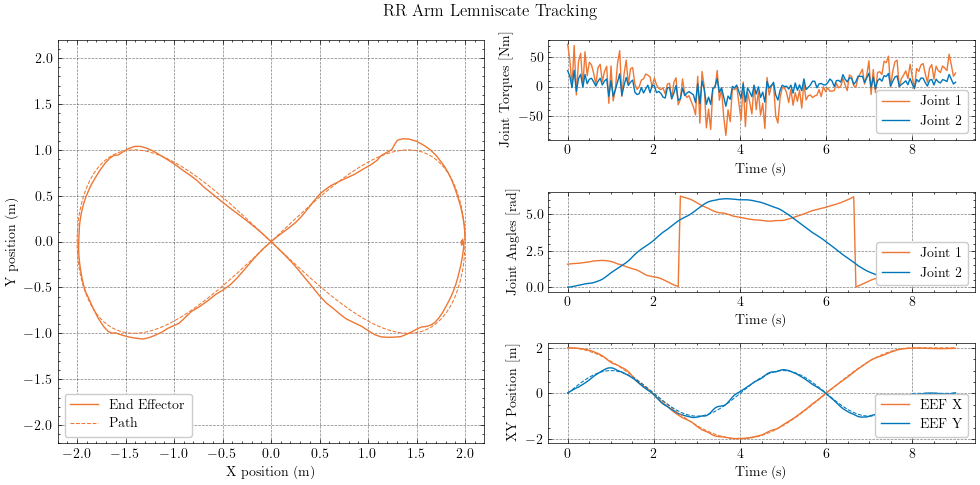

In [33]:
# Define helper functions to get some data on path tracking success
def mean_position_error(eef_positions, path_positions):
    return np.mean(
        np.linalg.norm(eef_positions - path_positions, axis=1)
    )

# Plot the results
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8.5), gridspec_kw={'height_ratios': [2.3, 1]})
fig, axd = plt.subplot_mosaic([['p', 't'], ['p', 'ja'], ['p', 'xy']], figsize=(10, 5), layout="constrained")
fig.suptitle("RR Arm Lemniscate Tracking")

eef_positions = fk_v(states[:, 0], states[:, 2])
path_positions = path.get_points(times)
# print(path_positions)

p = axd['p'].plot(eef_positions[:, 0], eef_positions[:, 1], label="End Effector")
axd['p'].plot(path_positions[:, 0], path_positions[:, 1], label="Path",
              ls="--", linewidth=0.75, color=p[0].get_color())
axd['p'].set(ylabel="Y position (m)", xlabel="X position (m)", ylim=(-2.2, 2.2), xlim=(-2.2, 2.2))
axd['p'].legend(loc="lower left")

axd['t'].plot(times, controls[:, 0], label="Joint 1")
axd['t'].plot(times, controls[:, 1], label="Joint 2")

axd['t'].set(xlabel="Time (s)", ylabel="Joint Torques [Nm]")
axd['t'].legend(loc="lower right")

axd['ja'].plot(times, states[:, 0], label="Joint 1")
axd['ja'].plot(times, states[:, 2], label="Joint 2")

axd['ja'].set(xlabel="Time (s)", ylabel="Joint Angles [rad]")
axd['ja'].legend(loc="lower right")

p = axd['xy'].plot(times, eef_positions[:, 0], label="EEF X")
q = axd['xy'].plot(times, eef_positions[:, 1], label="EEF Y")
axd['xy'].plot(times, path_positions[:, 0],
               ls="--", linewidth=0.75, color=p[0].get_color())
axd['xy'].plot(times, path_positions[:, 1],
               ls="--", linewidth=0.75, color=q[0].get_color())

axd['xy'].set(xlabel="Time (s)", ylabel="XY Position [m]")
axd['xy'].legend(loc="lower right")

plt.tight_layout()
fig.savefig("figs/arm_traj_follow.png")

print("Mean Position Error: {:.4f} mm".format(1e3 * mean_position_error(eef_positions[:, :2], path_positions)))

In [205]:
print(np.max(states[:, 1]), np.max(states[:, 3]))

1.3814171088650917 2.568292257932244
